** Описание **
Построить графики распределения в спам и не спам множествах следующих признаков:

•	Количество слов на странице
•	Количество слов в заголовке страниц (слова в теге <html><head><title > Some text </title>)
•	Средняя длинна слова
•	Количество слов в анкорах ссылок (<html><body><a> Some text </a>) # Общее кол-во или среднее кол-во?



In [1]:
# !pip install chardet

In [3]:
import sys
import base64
import random
import chardet
import codecs
from re import sub

from nltk.stem import SnowballStemmer
from HTMLParser import HTMLParser

stemmer = SnowballStemmer("russian");

 ** HTML Parser **
Тут мы можем распарсить страницу, выделить текст, заголовок, текст в ссылках документа

In [4]:
from collections import defaultdict

In [56]:
class SpamHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self.__text = []
        self.data = defaultdict(list)

        self.curr_tag = None

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self.__text.append('\n\n')
        elif tag == 'br':
            self.__text.append('\n')
        elif tag == 'title':
            self.curr_tag = tag
        elif tag == 'a':
            self.curr_tag = tag
            
    def handle_data(self, data):
        if self.curr_tag:
            self.data[self.curr_tag].append(len(data.strip().split(" ")))

        text = data.strip()
        if len(text) > 0:
            text = sub('[ \t\r\n]+', ' ', text)
            self.__text.append(text + ' ')
            
    def handle_endtag(self, tag):
        self.curr_tag = None

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self.__text.append('\n\n')

    def text(self):
        return ''.join(self.__text).strip()

** Сбор статистики **
Класс отвечает за сбор статистики

In [59]:
import numpy as np

In [124]:
class Stat:
    def __init__(self):
            self.points = []
            self.spam = []
            self.notspam = []
                            
            
class StatsCollector:
    def __init__(self):
        self.total_words = Stat();
        self.header_words = Stat();
        self.average_word_length = Stat();
        self.links_words = Stat();
        
    def collect(self, mark, pageInb64, url):
        html = base64.b64decode(pageInb64).decode('utf-8')

        parser = SpamHTMLParser()
        parser.feed(html)
        
        total_words = int(len(parser.text().split(" ")))
        if "title" in parser.data.keys():
            header_words = int(np.sum(parser.data["title"]))
        else:
            header_words = 0
        average_word_length = int(np.mean([len(w) for w in parser.text().split(" ")]))
        if "a" in parser.data.keys():
            links_words = int(np.sum(parser.data["a"]))
        else:
            links_words = 0
    
        if mark == 0: # notspam
            self.total_words.notspam.append(total_words)
            self.header_words.notspam.append(header_words)
            self.average_word_length.notspam.append(average_word_length)
            self.links_words.notspam.append(links_words)
            
        if mark == 1: # notspam
            self.total_words.spam.append(total_words)
            self.header_words.spam.append(header_words)
            self.average_word_length.spam.append(average_word_length)
            self.links_words.spam.append(links_words)
        
        self.total_words.points.append(mark)
        self.header_words.points.append(mark)
        self.average_word_length.points.append(mark)
        self.links_words.points.append(mark)
        
        parser.close();
                


** Обрабатываем входной файл **
Входной файл  ./data/train-set-ru-b64-utf-8.txt 
Формат - поля разделенные табуляциями
0 - идентификатор документа
1 - метка класса 0 - не спам, 1 - спам
2 - урл документа
3 - документ в кодировке base64


In [125]:
from collections import Counter

In [126]:
DATA_FILE  = './data/train-set-ru-b64-utf-8.txt'

stats_collector = StatsCollector()
i=0

with open (DATA_FILE) as df:
    for i, line in enumerate(df):
        line = line.strip()
        parts = line.split()
        stats_collector.collect(int(parts[1]), parts[3], parts[2])
        
        sys.stdout.write('\r' + "%s" % (i))
        sys.stdout.flush()

7043

In [127]:
def values2xy(values):
    c = Counter(values)
    a = np.array(c.items())
    sorted_a = np.sort(a.view('i8,i8'), order=['f0'], axis=0).view(np.int)
    x = sorted_a[:, 0]
    y = sorted_a[:, 1]
    
    return x, y

In [235]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_stats(stat, title):
    plt.figure(figsize=(10, 5))
    x, y = values2xy(stat["spam"])
    plt.plot(x, y, "r")

    x, y = values2xy(stat["notspam"])
    plt.plot(x, y, "b")
    plt.grid(True)
    plt.title(title)
    
def plot_stats_hist(stat, title):
    plt.figure(figsize=(10, 5))
    y, x = np.histogram(stat["spam"], bins=100)
    plt.plot(x[1:], y, "r")
    
    y, x = np.histogram(stat["notspam"], bins=100)
    plt.plot(x[1:], y, "b")
    plt.grid(True)
    plt.title(title)

** Тут строим графики **
1 - Количество слов в документах спам и не спам множеств
2 - Количество слов в заголовках спам и не спам множеств
3 - Средняя длина слова для спам и не спам множеств
4 - Количество слов в ссылках спам и не спам множеств

In [236]:
total_words = {
    "spam": np.sort(filter(lambda x: x < 10000, stats_collector.total_words.spam)),
    "notspam": np.sort(filter(lambda x: x < 10000, stats_collector.total_words.notspam)),
}

In [237]:
header_words = {
    "spam": filter(lambda x: x < 80, stats_collector.header_words.spam),
    "notspam": filter(lambda x: x < 80, stats_collector.header_words.notspam),
}

In [238]:
average_word_length = {
    "spam": filter(lambda x: x < 40, stats_collector.average_word_length.spam),
    "notspam": filter(lambda x: x < 40, stats_collector.average_word_length.notspam),
}

In [239]:
links_words = {
    "spam": filter(lambda x: x < 2000, stats_collector.links_words.spam),
    "notspam": filter(lambda x: x < 2000, stats_collector.links_words.notspam),
}

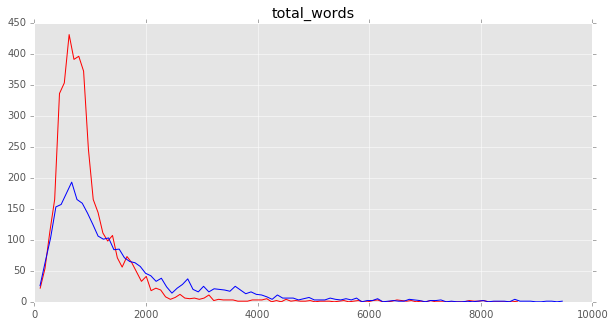

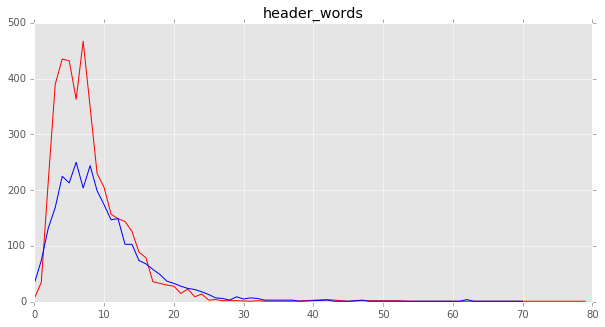

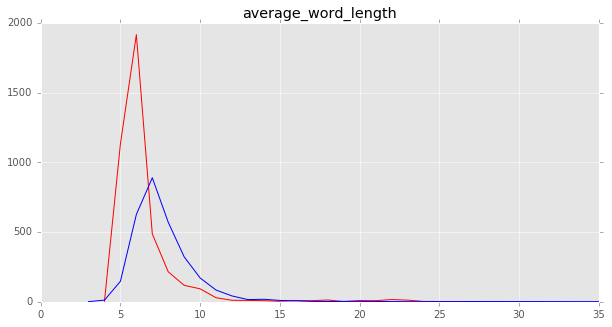

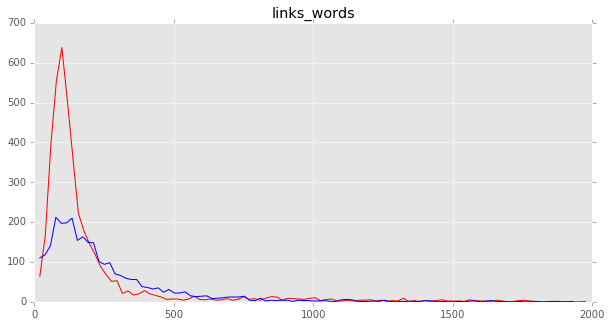

In [240]:
plot_stats_hist(total_words, "total_words")
plot_stats(header_words, "header_words")
plot_stats(average_word_length, "average_word_length")
plot_stats_hist(links_words, "links_words")